# Setup

In [ ]:
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm
import torch
import torch.nn as nn
from sklearn.metrics import brier_score_loss
from sklearn import preprocessing
import skopt
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Prepare Training- and Test Data

In [ ]:
# load train data
with open('/content/drive/MyDrive/Colab_Projects/AML_final_project/data/data_train.pt', 'rb') as file:
    X_TRAIN, y_TRAIN = pickle.load(file)

scaler = preprocessing.StandardScaler().fit(X_TRAIN)
X_TRAIN = scaler.transform(X_TRAIN)
data_TRAIN = np.concatenate((y_TRAIN, X_TRAIN), axis=1)
del X_TRAIN
del y_TRAIN
data_TRAIN = torch.tensor(data_TRAIN).float()
data_TRAIN = data_TRAIN.to("cuda")

split = 0.8
split_index = int(data_TRAIN.shape[0]*0.8)
data_train = data_TRAIN[:split_index] 
data_test = data_TRAIN[split_index:]

del data_TRAIN

# load test data
with open('/content/drive/MyDrive/Colab_Projects/AML_final_project/data/data_test.pt', 'rb') as file:
    X_TEST, y_TEST = pickle.load(file)
X_TEST = scaler.transform(X_TEST)
data_TEST = np.concatenate((y_TEST,X_TEST), axis=1)
data_TEST = torch.tensor(data_TEST).float()
data_TEST = data_TEST.to("cuda")

# Create Network Model

In [ ]:
class MLP(nn.Module):
  '''implements a multilayer perceptron with sigmoid output activation
     input_dim    --> dimension of input vector (number of dataframe columns)
     hidden_dim   --> dimension of hidden layers
     hidden_depth --> number of hidden layers '''

  def __init__(self, input_dim, hidden_dim, hidden_depth, dropout_p):
    super(MLP, self).__init__()

    self.input_dim    = input_dim
    self.hidden_dim   = hidden_dim
    self.hidden_depth = hidden_depth
    self.dropout_p    = dropout_p

    self.drop_layer = nn.Dropout(p=dropout_p)

    self.layers = nn.ModuleDict()

    self.layers['fcl_in'] = nn.Linear(self.input_dim, self.hidden_dim) 

    for i in range(self.hidden_depth):
      self.layers['fcl_hidden_' + str(i)] = nn.Linear(self.hidden_dim, self.hidden_dim)

    self.layers['fcl_out']  = nn.Linear(self.hidden_dim, 2)


  def forward(self, x):
    x = nn.functional.relu(self.layers['fcl_in'](x))
    x = self.drop_layer(x)
    for i in range(self.hidden_depth):
      x = nn.functional.relu(self.layers['fcl_hidden_' + str(i)](x))
      x = self.drop_layer(x)
    x = torch.sigmoid(self.layers['fcl_out'](x))

    return x

# Tune Hyperparameters

In [ ]:
### configure Hyperparameters
"""INPUT_DIM     = data_train.shape[1] -2
HIDDEN_DIM    = 256
HIDDEN_DEPTH  = 4
BATCH_SIZE    = 128
N_EPOCHS      = 40
LEARNING_RATE = 0.001
LOSS          = nn.BCELoss() # (Binary Cross Entropy)
#BCE = 0.1144
#brier(hos) = 0.051887
#brier(fat) = 0.0091"""

INPUT_DIM     = data_train.shape[1] -2
HIDDEN_DIM    = 256
HIDDEN_DEPTH  = 4
BATCH_SIZE    = 128
N_EPOCHS      = 40
LEARNING_RATE = 0.001
DROPOUT_P     = 0.05
LOSS          = nn.BCELoss() # (Binary Cross Entropy)

# Train Network

In [ ]:
loss_train  = []
loss_test   = []

brier_train = []
brier_test  = []

# initializing network and optimizer
net = MLP(INPUT_DIM, HIDDEN_DIM, HIDDEN_DEPTH, DROPOUT_P).to("cuda")
optim = torch.optim.Adam(net.parameters(), lr = LEARNING_RATE)

# create dataloader
train_generator = torch.utils.data.DataLoader(dataset = data_train, batch_size = BATCH_SIZE, shuffle = True)

for i in range(N_EPOCHS):
  print("epoch " + str(i+1) + ":", end=" ")

  for batch in tqdm(train_generator, leave = True, position = 0):

    optim.zero_grad()

    target     = batch[:,[0,1]]
    prediction = net(batch[:, 2:]) 

    loss = LOSS(prediction, target)
    loss.backward()

    optim.step()
  
  # record loss and brier score after every epoch
  with torch.no_grad():
    net.eval()

    n = int(data_train.shape[0]/2)

    target_train     = data_train[:n,[0,1]].cpu()
    target_test      = data_test[:,[0,1]].cpu()

    prediction_train = net(data_train[:n, 2:]).cpu()
    prediction_test  = net(data_test[:, 2:]).cpu()
    print(prediction_test)
    
    loss_train.append(LOSS(prediction_train, target_train))
    loss_test.append(LOSS(prediction_test, target_test))

    brier_train.append([brier_score_loss(target_train[:,0], prediction_train[:,0]), brier_score_loss(target_train[:,1], prediction_train[:,1])])
    brier_test.append([brier_score_loss(target_test[:,0], prediction_test[:,0]), brier_score_loss(target_test[:,1], prediction_test[:,1])])

    net.train()


epoch 1: 

100%|██████████| 14461/14461 [01:01<00:00, 237.03it/s]


tensor([[3.0457e-01, 1.3449e-01],
        [3.9611e-02, 8.8507e-05],
        [2.4369e-02, 8.4705e-05],
        ...,
        [1.4338e-02, 3.2889e-06],
        [7.9067e-02, 5.6886e-03],
        [5.1047e-02, 2.2089e-04]])
epoch 2: 

100%|██████████| 14461/14461 [01:01<00:00, 236.07it/s]


tensor([[3.0348e-01, 1.1439e-01],
        [4.0298e-02, 7.2220e-06],
        [2.9738e-02, 1.4802e-05],
        ...,
        [7.1902e-03, 8.5596e-10],
        [8.1899e-02, 1.3842e-03],
        [5.0436e-02, 9.0888e-05]])
epoch 3: 

100%|██████████| 14461/14461 [01:01<00:00, 235.36it/s]


tensor([[3.0050e-01, 1.3829e-01],
        [1.6750e-02, 1.7329e-07],
        [1.3486e-02, 6.3803e-06],
        ...,
        [2.1269e-03, 3.2979e-13],
        [4.6787e-02, 1.9695e-04],
        [3.0205e-02, 9.8381e-06]])
epoch 4: 

100%|██████████| 14461/14461 [01:01<00:00, 236.46it/s]


tensor([[3.1340e-01, 1.0289e-01],
        [4.5642e-02, 1.5843e-04],
        [3.2709e-02, 8.8848e-04],
        ...,
        [1.3242e-02, 4.4856e-07],
        [7.6017e-02, 1.6150e-03],
        [6.2942e-02, 9.2220e-04]])
epoch 5: 

100%|██████████| 14461/14461 [01:01<00:00, 235.52it/s]


tensor([[3.3921e-01, 1.4803e-01],
        [2.0902e-02, 4.4305e-06],
        [1.9657e-02, 6.8335e-06],
        ...,
        [5.3188e-03, 4.0329e-09],
        [5.2648e-02, 4.4831e-04],
        [2.7137e-02, 1.6882e-05]])
epoch 6: 

100%|██████████| 14461/14461 [01:01<00:00, 235.86it/s]


tensor([[2.9637e-01, 1.3710e-01],
        [3.2796e-02, 4.8738e-07],
        [1.5873e-02, 4.8543e-08],
        ...,
        [6.5628e-03, 8.1064e-13],
        [6.6447e-02, 2.2963e-04],
        [4.1071e-02, 8.8328e-06]])
epoch 7: 

100%|██████████| 14461/14461 [01:01<00:00, 236.01it/s]


tensor([[3.1650e-01, 1.3675e-01],
        [3.6182e-02, 2.1455e-05],
        [2.7432e-02, 6.2559e-06],
        ...,
        [8.5852e-03, 1.1296e-09],
        [6.9680e-02, 1.3210e-03],
        [5.3471e-02, 3.7330e-04]])
epoch 8: 

100%|██████████| 14461/14461 [01:01<00:00, 234.92it/s]


tensor([[3.2086e-01, 1.2371e-01],
        [3.3347e-02, 1.0119e-05],
        [1.8061e-02, 1.5531e-06],
        ...,
        [5.5075e-03, 1.5466e-09],
        [6.0061e-02, 6.5289e-04],
        [3.8931e-02, 4.6614e-05]])
epoch 9: 

100%|██████████| 14461/14461 [01:01<00:00, 235.16it/s]


tensor([[3.3826e-01, 1.6561e-01],
        [2.6681e-02, 3.1301e-05],
        [1.7577e-02, 1.1433e-05],
        ...,
        [4.0450e-03, 1.1676e-07],
        [5.9309e-02, 7.9491e-04],
        [3.3977e-02, 1.2812e-04]])
epoch 10: 

100%|██████████| 14461/14461 [01:01<00:00, 234.69it/s]


tensor([[3.1160e-01, 1.2434e-01],
        [2.7560e-02, 1.0584e-06],
        [1.7723e-02, 3.1086e-07],
        ...,
        [6.7138e-03, 6.5815e-11],
        [6.6387e-02, 1.8895e-04],
        [4.2085e-02, 4.8991e-05]])
epoch 11: 

100%|██████████| 14461/14461 [01:01<00:00, 236.90it/s]


tensor([[2.9983e-01, 1.4274e-01],
        [3.3603e-02, 4.2569e-06],
        [1.9362e-02, 2.4797e-07],
        ...,
        [6.8746e-03, 1.1993e-11],
        [6.5905e-02, 9.8249e-06],
        [4.7922e-02, 1.2731e-04]])
epoch 12: 

100%|██████████| 14461/14461 [01:01<00:00, 235.36it/s]


tensor([[3.5032e-01, 1.9794e-01],
        [2.8489e-02, 2.7852e-06],
        [1.3010e-02, 1.5905e-07],
        ...,
        [5.5519e-03, 4.5562e-10],
        [5.6635e-02, 2.3671e-04],
        [4.3983e-02, 7.8835e-05]])
epoch 13: 

100%|██████████| 14461/14461 [01:01<00:00, 235.67it/s]


tensor([[3.3830e-01, 1.3362e-01],
        [2.3764e-02, 1.0985e-06],
        [1.4409e-02, 1.2266e-07],
        ...,
        [3.8717e-03, 4.0904e-11],
        [4.0120e-02, 2.3790e-05],
        [3.6347e-02, 8.6358e-05]])
epoch 14: 

100%|██████████| 14461/14461 [01:01<00:00, 235.06it/s]


tensor([[3.2170e-01, 1.1816e-01],
        [2.5907e-02, 4.8555e-07],
        [2.3732e-02, 2.0812e-06],
        ...,
        [3.9369e-03, 9.4269e-13],
        [7.2850e-02, 3.9723e-05],
        [3.8731e-02, 3.1155e-05]])
epoch 15: 

100%|██████████| 14461/14461 [01:01<00:00, 235.30it/s]


tensor([[3.2841e-01, 1.7796e-01],
        [2.7019e-02, 6.5136e-08],
        [2.1570e-02, 1.8516e-07],
        ...,
        [4.7854e-03, 1.6931e-13],
        [6.0483e-02, 1.0219e-05],
        [4.0084e-02, 3.7729e-06]])
epoch 16: 

100%|██████████| 14461/14461 [01:01<00:00, 236.12it/s]


tensor([[3.4117e-01, 1.5495e-01],
        [3.2392e-02, 2.1109e-05],
        [1.5843e-02, 7.1878e-06],
        ...,
        [8.0629e-03, 1.0304e-08],
        [7.1568e-02, 7.8762e-04],
        [4.4439e-02, 1.9004e-04]])
epoch 17: 

100%|██████████| 14461/14461 [01:01<00:00, 236.11it/s]


tensor([[3.4205e-01, 1.7760e-01],
        [2.6539e-02, 7.6258e-06],
        [1.3545e-02, 1.4260e-06],
        ...,
        [5.7486e-03, 5.7737e-10],
        [5.5982e-02, 1.7357e-04],
        [3.7800e-02, 7.3513e-05]])
epoch 18: 

100%|██████████| 14461/14461 [01:01<00:00, 236.13it/s]


tensor([[3.3705e-01, 1.5638e-01],
        [3.5623e-02, 2.6102e-06],
        [2.3338e-02, 8.1847e-07],
        ...,
        [1.1727e-02, 3.8035e-10],
        [7.0024e-02, 5.7658e-04],
        [4.7654e-02, 5.8168e-05]])
epoch 19: 

100%|██████████| 14461/14461 [01:01<00:00, 235.31it/s]


tensor([[3.2068e-01, 1.1383e-01],
        [3.8942e-02, 3.6492e-06],
        [1.6613e-02, 8.3921e-06],
        ...,
        [7.3921e-03, 1.4177e-12],
        [8.0392e-02, 5.4502e-05],
        [4.6314e-02, 7.0940e-05]])
epoch 20: 

100%|██████████| 14461/14461 [01:01<00:00, 235.09it/s]


tensor([[2.7285e-01, 1.2415e-01],
        [3.2881e-02, 2.1473e-06],
        [2.6484e-02, 9.9906e-06],
        ...,
        [5.0703e-03, 3.6656e-12],
        [6.8582e-02, 6.0281e-05],
        [3.8745e-02, 7.0639e-06]])
epoch 21: 

100%|██████████| 14461/14461 [01:01<00:00, 235.17it/s]


tensor([[3.1381e-01, 1.2326e-01],
        [3.8299e-02, 1.3376e-05],
        [2.3400e-02, 8.5206e-06],
        ...,
        [7.1478e-03, 4.6136e-10],
        [8.1008e-02, 6.9745e-04],
        [4.4199e-02, 1.4618e-04]])
epoch 22: 

100%|██████████| 14461/14461 [01:01<00:00, 235.81it/s]


tensor([[3.3233e-01, 1.9731e-01],
        [3.2778e-02, 3.1771e-05],
        [1.9157e-02, 3.3432e-05],
        ...,
        [3.6234e-03, 3.9336e-10],
        [8.9029e-02, 2.8320e-04],
        [4.3152e-02, 6.1313e-04]])
epoch 23: 

100%|██████████| 14461/14461 [01:01<00:00, 235.65it/s]


tensor([[3.6056e-01, 1.1452e-01],
        [3.8521e-02, 2.1103e-05],
        [2.0286e-02, 4.4848e-06],
        ...,
        [8.3417e-03, 1.6283e-10],
        [7.4611e-02, 5.2136e-04],
        [4.6300e-02, 1.8317e-04]])
epoch 24: 

100%|██████████| 14461/14461 [01:01<00:00, 235.49it/s]


tensor([[3.3149e-01, 1.7992e-01],
        [3.1874e-02, 1.3331e-05],
        [1.8560e-02, 6.3537e-06],
        ...,
        [4.4663e-03, 4.5591e-12],
        [7.0968e-02, 4.3766e-04],
        [4.4329e-02, 1.3063e-04]])
epoch 25: 

100%|██████████| 14461/14461 [01:01<00:00, 235.14it/s]


tensor([[3.3430e-01, 1.7613e-01],
        [2.8852e-02, 1.0772e-05],
        [1.4667e-02, 1.0144e-07],
        ...,
        [2.4966e-03, 5.4363e-14],
        [6.7154e-02, 1.4816e-03],
        [3.2995e-02, 3.4768e-05]])
epoch 26: 

100%|██████████| 14461/14461 [01:01<00:00, 235.13it/s]


tensor([[3.4108e-01, 1.5623e-01],
        [3.1526e-02, 2.3692e-06],
        [1.6276e-02, 2.2871e-07],
        ...,
        [5.2968e-03, 7.2837e-14],
        [5.3753e-02, 4.5203e-04],
        [3.7245e-02, 1.5070e-05]])
epoch 27: 

100%|██████████| 14461/14461 [01:01<00:00, 234.66it/s]


tensor([[3.4017e-01, 1.1522e-01],
        [3.3150e-02, 2.7123e-06],
        [1.5624e-02, 3.1763e-09],
        ...,
        [5.7507e-03, 8.8142e-14],
        [4.9633e-02, 1.0475e-04],
        [4.1433e-02, 2.8914e-05]])
epoch 28: 

100%|██████████| 14461/14461 [01:01<00:00, 236.92it/s]


tensor([[3.6018e-01, 1.3526e-01],
        [3.6474e-02, 1.0216e-04],
        [1.3101e-02, 8.5257e-06],
        ...,
        [6.9654e-03, 7.6253e-09],
        [5.5566e-02, 6.1517e-04],
        [3.8701e-02, 4.8887e-04]])
epoch 29: 

100%|██████████| 14461/14461 [01:01<00:00, 235.56it/s]


tensor([[3.0110e-01, 1.2817e-01],
        [4.1118e-02, 1.1772e-05],
        [2.1904e-02, 4.2051e-07],
        ...,
        [8.2616e-03, 2.5322e-12],
        [6.6252e-02, 1.7303e-04],
        [4.2570e-02, 4.1279e-05]])
epoch 30: 

100%|██████████| 14461/14461 [01:01<00:00, 235.09it/s]


tensor([[2.5776e-01, 1.1461e-01],
        [3.1232e-02, 1.9835e-06],
        [1.6364e-02, 2.9599e-08],
        ...,
        [4.4447e-03, 1.5009e-14],
        [6.8381e-02, 1.6883e-04],
        [3.8337e-02, 1.5959e-05]])
epoch 31: 

100%|██████████| 14461/14461 [01:01<00:00, 235.72it/s]


tensor([[3.3821e-01, 1.6355e-01],
        [3.5600e-02, 4.1274e-06],
        [2.0873e-02, 6.1302e-08],
        ...,
        [5.6282e-03, 1.9742e-15],
        [7.7045e-02, 7.6440e-04],
        [3.8503e-02, 1.5447e-05]])
epoch 32: 

100%|██████████| 14461/14461 [01:01<00:00, 234.24it/s]


tensor([[3.1307e-01, 1.5893e-01],
        [2.9865e-02, 3.7296e-06],
        [1.5279e-02, 3.0433e-08],
        ...,
        [2.9554e-03, 1.7325e-14],
        [5.2997e-02, 2.6997e-04],
        [3.3285e-02, 1.6386e-05]])
epoch 33: 

100%|██████████| 14461/14461 [01:01<00:00, 233.58it/s]


tensor([[3.6383e-01, 1.6034e-01],
        [3.4263e-02, 1.4937e-05],
        [1.5530e-02, 1.5211e-07],
        ...,
        [4.7734e-03, 4.3135e-13],
        [1.0771e-01, 1.5032e-04],
        [3.7190e-02, 7.4276e-05]])
epoch 34: 

100%|██████████| 14461/14461 [01:01<00:00, 234.06it/s]


tensor([[3.2894e-01, 1.4983e-01],
        [3.5586e-02, 2.1318e-05],
        [1.6811e-02, 8.0466e-07],
        ...,
        [4.1532e-03, 1.0964e-12],
        [7.2487e-02, 6.5716e-04],
        [3.9776e-02, 9.9348e-05]])
epoch 35: 

100%|██████████| 14461/14461 [01:01<00:00, 233.60it/s]


tensor([[2.8353e-01, 1.2841e-01],
        [3.0537e-02, 1.3324e-05],
        [1.2951e-02, 4.5149e-07],
        ...,
        [5.6580e-03, 3.4353e-11],
        [5.0846e-02, 5.0006e-04],
        [3.1524e-02, 3.8799e-05]])
epoch 36: 

100%|██████████| 14461/14461 [01:01<00:00, 235.08it/s]


tensor([[2.9520e-01, 1.6041e-01],
        [3.8408e-02, 8.4939e-06],
        [1.5712e-02, 5.2130e-07],
        ...,
        [3.9142e-03, 3.4438e-15],
        [6.7029e-02, 6.9355e-04],
        [3.9650e-02, 1.6274e-05]])
epoch 37: 

100%|██████████| 14461/14461 [01:01<00:00, 235.10it/s]


tensor([[3.5150e-01, 1.3443e-01],
        [3.5456e-02, 6.9241e-07],
        [2.1960e-02, 1.5041e-08],
        ...,
        [7.7933e-03, 3.3350e-15],
        [7.0034e-02, 3.0475e-04],
        [4.1668e-02, 9.2270e-06]])
epoch 38: 

100%|██████████| 14461/14461 [01:01<00:00, 234.19it/s]


tensor([[3.5066e-01, 1.4781e-01],
        [3.3835e-02, 4.4898e-08],
        [1.9508e-02, 1.0186e-10],
        ...,
        [5.1610e-03, 5.4689e-20],
        [5.2203e-02, 8.1814e-06],
        [4.1660e-02, 1.5199e-06]])
epoch 39: 

100%|██████████| 14461/14461 [01:02<00:00, 232.37it/s]


tensor([[2.9938e-01, 1.1975e-01],
        [2.9516e-02, 1.6161e-06],
        [1.6123e-02, 5.9843e-08],
        ...,
        [4.9709e-03, 6.0761e-14],
        [7.0436e-02, 5.1929e-04],
        [3.6525e-02, 2.1025e-05]])
epoch 40: 

100%|██████████| 14461/14461 [01:02<00:00, 230.35it/s]


tensor([[3.2106e-01, 1.4664e-01],
        [3.8662e-02, 4.2450e-05],
        [2.4617e-02, 2.8081e-05],
        ...,
        [9.1740e-03, 1.7587e-10],
        [5.7669e-02, 9.1322e-04],
        [4.5813e-02, 2.2582e-04]])


# Evaluate Performance

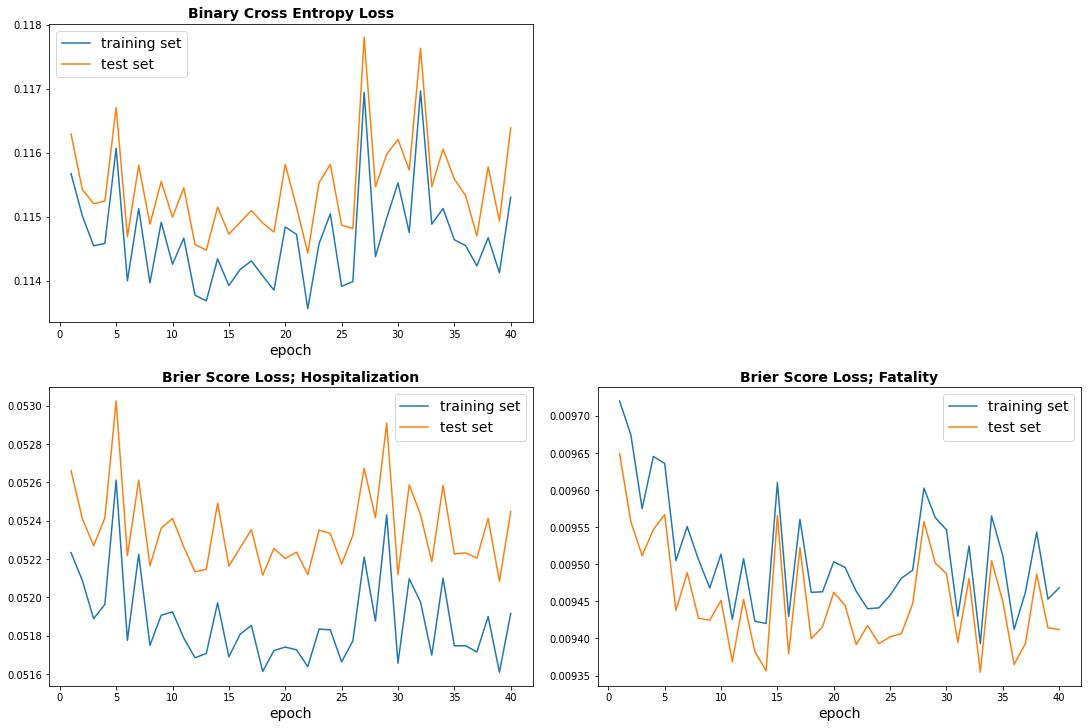

final cross entropy loss on test set:  0.11638884
final brier score loss on test set (hospitalization):  0.05244767754113703
final brier score loss on test set (fatality):  0.009411998055489756


In [ ]:
loss_train  = np.array(loss_train)
loss_test   = np.array(loss_test)
brier_train = np.array(brier_train)
brier_test  = np.array(brier_test)

x = list(range(1, N_EPOCHS +1))

fig, ax = plt.subplots(2,2, figsize = (15, 10), constrained_layout=True)

ax[0][0].plot(x, loss_train, label = "training set")
ax[0][0].plot(x, loss_test, label = "test set")
ax[0][0].set_xlabel("epoch", fontsize = 14)
ax[0][0].set_title("Binary Cross Entropy Loss", fontsize = 14, fontweight="bold")
ax[0][0].legend(fontsize = 14)

ax[0][1].axis("off")

ax[1][0].plot(x, brier_train[:,0], label = "training set")
ax[1][0].plot(x, brier_test[:,0], label = "test set")
ax[1][0].set_xlabel("epoch", fontsize = 14)
ax[1][0].set_title("Brier Score Loss; Hospitalization", fontsize = 14, fontweight="bold")
ax[1][0].legend(fontsize = 14)

ax[1][1].plot(x, brier_train[:,1], label = "training set")
ax[1][1].plot(x, brier_test[:,1], label = "test set")
ax[1][1].set_xlabel("epoch", fontsize = 14)
ax[1][1].set_title("Brier Score Loss; Fatality", fontsize = 14, fontweight="bold")
ax[1][1].legend(fontsize = 14)

plt.show()

print("final cross entropy loss on test set: ", loss_test[-1])
print("final brier score loss on test set (hospitalization): ", brier_test[-1,0])
print("final brier score loss on test set (fatality): ", brier_test[-1,1])

In [ ]:
loss_dict = {"BNC":{"train":loss_train, "eval":loss_test}, "Brier":{"hosp":{"train":brier_train[:,0], "eval":brier_test[:,0]}, "death":{"train":brier_train[:,1], "eval":brier_test[:,1]}}}
np.save('/content/drive/MyDrive/Colab_Projects/AML_final_project/data/losses_model_3.pt', loss_dict) 
torch.save(net.state_dict(), '/content/drive/MyDrive/Colab_Projects/AML_final_project/data/MLP_model_3.pt')